In [1]:
import pandas as pd
import os
import re
import requests
from bs4 import BeautifulSoup
import folium
from geopy.geocoders import Nominatim

#get the data from source, filtering only for country=USA
base_url = 'https://supercharge.info/service/supercharge/allSites'
superchargers=[]
plain_json = requests.get(base_url).json()
for i in plain_json:
  if i['address']['country']=='USA':
    superchargers.append(i)
pd.set_option('display.max_columns', None)
df = pd.json_normalize(superchargers)



In [3]:
df.shape

(982, 24)

In [4]:
#visualize the supercharger locations.

map = folium.Map(location=[37, -121], zoom_start=7)
def plotDot(point):
    folium.CircleMarker(location=[point['gps.latitude'], point['gps.longitude']],
                        radius=2,
                        weight=1).add_to(map)
    
df.apply(plotDot, axis = 1)
map.fit_bounds(map.get_bounds())
map

In [5]:
#We export these Foursquare API client secrets through environment variables os as to not leak the secrets
# Run the following to exports, before starting jupyter notebook
# export CLIENT_ID=***
# export CLIENT_SECRET=***
CLIENT_ID=os.getenv('CLIENT_ID')
CLIENT_SECRET=os.getenv('CLIENT_SECRET')

In [6]:
df_valid = df
df_valid.shape

(982, 24)

In [8]:
# In this case we write a function that given neighborhood, lat/long co-ordinates and a radius returns a dataframe  
# of venues with their coordinates and categories
LIMIT=100
VERSION = '20180605'
def getNearbyVenues(names, latitudes, longitudes, radius=500):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
      CLIENT_ID,
      CLIENT_SECRET,
      VERSION,
      lat,
      lng,
      radius,
      LIMIT)

    # make the GET request
    results = requests.get(url)
    if results.status_code==200 and results.json()["response"]["groups"] != None and len(results.json()["response"]["groups"]) > 0:
      results = results.json()["response"]["groups"][0]["items"]
    else:
      continue
    # return only relevant information for each nearby venue
    venues_list.append([(
      name,
      lat,
      lng,
      v['venue']['name'],
      v['venue']['location']['lat'],
      v['venue']['location']['lng'],
      v['venue']['categories'][0]['name']) for v in results])

  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighborhood',
                           'Neighborhood Latitude',
                           'Neighborhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return (nearby_venues)

In [9]:
nearby_venues=getNearbyVenues(df_valid['name'], df_valid['gps.latitude'], df_valid['gps.longitude'])

San Juan Capistrano, CA
Glenwood Springs, CO
Grand Junction, CO
Hawthorne, CA
Buckeye, AZ
Kingman, AZ
Buellton, CA
Corning, CA
St. Augustine, FL
Port Orange, FL
Folsom - Iron Point Road, CA
Rosemont, IL
Atascadero, CA
Port St. Lucie, FL
Highland Park (SC), IL
Barstow, CA
Tifton, GA
Yuma, AZ
Indio, CA
Roseville, CA
Oxnard, CA
Gila Bend, AZ
Holbrook, AZ
El Centro, CA
Macon, GA
Greenwich, CT (north)
Greenwich, CT (south)
Fort Myers, FL
Silverthorne, CO
Milford, CT (north)
Milford, CT (south)
Savannah, GA
Hagerstown, MD
Albert Lea, MN
Las Vegas, NV
Edison, NJ
Albany, NY
JFK Airport, NY
Worthington, MN
Burlington, NC
Macedonia, OH
Detroit Lake, OR
Murdo, SD
Spearfish, SD
Santee, SC
Mishawaka, IN
East Greenwich, RI
Angola, IN
Rapid City, SD
Woodburn, OR
Richmond, CA
Beaver, UT
Farmington, NM
Goodland, KS
Somerset, PA
Ossining, NY
Grove City, PA
Gallup, NM
San Marcos, TX
Columbus, TX
Cranberry, PA
Maumee, OH
Plymouth, NC
Lumberton, NC
Mitchell, SD
Blanding, UT
Triadelphia, WV
Cheyenne, WY
Ple

Augusta - Belair Frontage Rd, GA
Richmond, VA
Madison - East Washington Ave, WI
Manchester, CT
Skokie, IL
Chicago - North Broadway, IL
Tampa, FL
Cambridge, MA
Manhattan Beach, CA
Phoenix - East Camelback Rd, AZ
Crescent City, CA
Rochester, NH
Hartford - Leibert Rd, CT
San Jose - Santana Row, CA
Salt Lake City - S. State Street, UT
El Paso, TX
Leesburg, VA
Freehold, NJ
Thousand Oaks - East Thousand Oaks Blvd, CA
Irvine - Michelson Dr, CA
Irvine - Main St, CA
Idaho Springs, CO
Morgan Hill, CA
Vienna, VA
Stockton, CA
San Antonio, TX
Dublin - Amador Plaza, CA
Washington - Wisconsin Ave NW, DC
Bandon, OR
Custer, SD
Coralville, IA
Sulphur Springs, TX
Montecito, CA
Macon - Tom Hill Sr Rd, GA
Plantation, FL
Watsonville, CA
Fairfield - Southbound, CT
Sioux City, IA
Philadelphia - City Center, PA
Gilroy - Gilroy Crossing, CA
Henrietta, TX
Los Gatos, CA
Sedona, AZ
Philadelphia - North 20th St, PA
Carlsbad, CA
Bethesda - Montgomery Mall East, MD
Chicago - North Halsted, IL
Downey - Lakewood Blvd, 

In [10]:
nearby_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Aberdeen, MD",9,9,9,9,9,9
"Aberdeen, WA",9,9,9,9,9,9
"Acworth, GA",16,16,16,16,16,16
"Adelanto, CA",3,3,3,3,3,3
"Alameda, CA",28,28,28,28,28,28
...,...,...,...,...,...,...
"York, PA",5,5,5,5,5,5
"Yorktown Heights, NY",11,11,11,11,11,11
"Yuba City, CA",8,8,8,8,8,8


In [55]:
# Generate a onehot encoding based on Venue Category add Neighborhood column to this oneshot dataframe
sc_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")
sc_onehot['name'] = nearby_venues['Neighborhood'] 
fixed_columns = [sc_onehot.columns[-1]] + list(sc_onehot.columns[:-1])
sc_onehot = sc_onehot[fixed_columns]
sc_onehot.head()

,name,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bavarian Restaurant,Belgian Restaurant,Bistro,Brasserie,Brazilian Restaurant,Breakfast Spot,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Cha Chaan Teng,Chaat Place,Chinese Restaurant,Churrascaria,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fondue Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hong Kong Restaurant,Hot Dog Joint,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,Soba Restaurant,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,"San Juan Capistrano, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"San Juan Capistrano, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"San Juan Capistrano, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"San Juan Capistrano, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"San Juan Capistrano, CA",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
# groupby Neighborhood 
sc_grouped = sc_onehot.groupby('name').mean().reset_index()
sc_grouped.shape

(963, 135)

In [68]:

# return top 5 venues for each neighborhood
num_top_venues = 5

for hood in sc_grouped[1:5]['name']:
    print("----"+hood+"----")
    temp = sc_grouped[sc_grouped['name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aberdeen, WA----
                     venue  freq
0     Fast Food Restaurant  0.33
1               Restaurant  0.11
2  New American Restaurant  0.11
3                     Café  0.11
4       Seafood Restaurant  0.11


----Acworth, GA----
                  venue  freq
0  Fast Food Restaurant  0.25
1    Chinese Restaurant  0.12
2    Mexican Restaurant  0.12
3        Breakfast Spot  0.06
4    Italian Restaurant  0.06


----Adelanto, CA----
                 venue  freq
0          Snack Place  0.33
1                 Food  0.33
2           Restaurant  0.33
3    Afghan Restaurant  0.00
4  Moroccan Restaurant  0.00


----Alameda, CA----
                  venue  freq
0            Food Truck  0.36
1     Korean Restaurant  0.07
2  Fast Food Restaurant  0.07
3            Bagel Shop  0.07
4        Sandwich Place  0.04




In [69]:
# write a function that returns the top k common venues.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [236]:
import numpy as np # library to handle data in a vectorized manner
# create the new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = sc_grouped['name']

for ind in np.arange(sc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Aberdeen, MD",Deli / Bodega,Italian Restaurant,Seafood Restaurant,Fast Food Restaurant,Burrito Place
1,"Aberdeen, WA",Fast Food Restaurant,Pizza Place,Chinese Restaurant,Café,New American Restaurant
2,"Acworth, GA",Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Deli / Bodega,Fried Chicken Joint
3,"Adelanto, CA",Food,Restaurant,Snack Place,Empanada Restaurant,Filipino Restaurant
4,"Alameda, CA",Food Truck,Fast Food Restaurant,Korean Restaurant,Bagel Shop,Burger Joint


In [237]:
#  find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(nearby_venues['Venue Category'].unique())))
nearby_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 134 uniques categories.


Venue Category
Fast Food Restaurant               1276
American Restaurant                1102
Sandwich Place                     1007
Pizza Place                        1003
Mexican Restaurant                  826
                                   ... 
Indonesian Restaurant                 1
Polish Restaurant                     1
Paella Restaurant                     1
Molecular Gastronomy Restaurant       1
Xinjiang Restaurant                   1
Name: Venue Category, Length: 134, dtype: int64

In [238]:
# list all the categories
unique_categories = nearby_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Mexican Restaurant, Italian Restaurant, Breakfast Spot, Restaurant, American Restaurant, Japanese Restaurant, Bakery, Sushi Restaurant, Diner, Steakhouse, Eastern European Restaurant, Pizza Place, Thai Restaurant, Sandwich Place, Tapas Restaurant, Fast Food Restaurant, Fried Chicken Joint, Café, Vietnamese Restaurant, Donut Shop, Chinese Restaurant, Fondue Restaurant, Taco Place, Food, Deli / Bodega, Asian Restaurant, Tex-Mex Restaurant, Wings Joint, BBQ Joint, Seafood Restaurant, Snack Place, Food Truck, Burger Joint, Soup Place, Burrito Place, Food Stand, Food Court, Brazilian Restaurant, Vegetarian / Vegan Restaurant, Bavarian Restaurant, Theme Restaurant, New American Restaurant, Gastropub, French Restaurant, Mediterranean Restaurant, Greek Restaurant, Cajun / Creole Restaurant, Hawaiian Restaurant, Hot Dog Joint, Noodle House, Salad Place, Comfort Food Restaurant, Korean Restaurant, Ramen Restaurant, Truck Stop, Bistro, Latin American Restaurant, Bagel Shop, North Indian Restauran

In [239]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [240]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Sri Lankan Restaurant, Hunan Restaurant, Grilled Meat Restaurant, Cuban Restaurant, Asian Restaurant, Chaat Place, Falafel Restaurant, Salvadoran Restaurant, Noodle House, Chinese Restaurant, German Restaurant, Eastern European Restaurant, Pizza Place, Belgian Restaurant, Churrascaria, Burrito Place, Dumpling Restaurant, Indonesian Restaurant, Kosher Restaurant, Southern / Soul Food Restaurant, South American Restaurant, Dim Sum Restaurant, South Indian Restaurant, Szechuan Restaurant, Hong Kong Restaurant, Brazilian Restaurant, Mexican Restaurant, Thai Restaurant, Shanghai Restaurant, Xinjiang Restaurant, North Indian Restaurant, Egyptian Restaurant, Halal Restaurant, Seafood Restaurant, Modern European Restaurant, Fast Food Restaurant, Truck Stop, African Restaurant, Cha Chaan Teng, Australian Restaurant, Russian Restaurant, Argentinian Restaurant, Caribbean Restaurant, Swiss Restaurant, Greek Restaurant, Sushi Restaurant, Empanada Restaurant, Japanese Curry Restaurant, BBQ Joint, Ta

In [241]:
# remove all the generalized categories, like Coffee Shop, Cafe, etc.
sc_venues = nearby_venues[nearby_venues['Venue Category'].isin(food_categories)].reset_index()
sc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,"San Juan Capistrano, CA",33.498458,-117.6632,Taqueria El Campeon,33.498982,-117.663416,Mexican Restaurant
1,1,"San Juan Capistrano, CA",33.498458,-117.6632,RICARDO'S PLACE RESTAURANT,33.496610,-117.662150,Mexican Restaurant
2,2,"San Juan Capistrano, CA",33.498458,-117.6632,Sundried Tomato Cafe,33.501037,-117.662777,Italian Restaurant
3,3,"San Juan Capistrano, CA",33.498458,-117.6632,El Molino De Oro,33.497109,-117.661986,Mexican Restaurant
4,7,"San Juan Capistrano, CA",33.498458,-117.6632,Cafe Mozart,33.498956,-117.662030,American Restaurant


In [242]:
print('There are {} unique FOOD categories.'.format(len(sc_venues['Venue Category'].unique())))

There are 102 unique FOOD categories.


In [103]:
print('There are {} uniques venues.'.format(len(sc_venues['Venue'].unique())))

There are 5465 uniques venues.


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

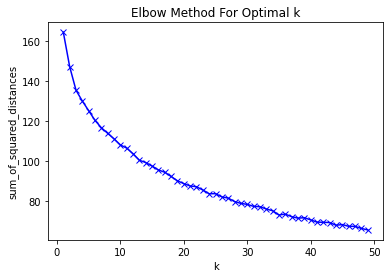

In [243]:
# Determine the optimal number of clusters for k-means clustering using Elbow Method
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(sc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

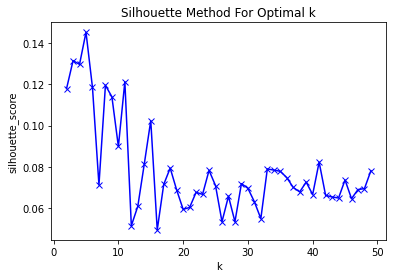

In [256]:
# Determine the optimal number of clusters for k-means clustering using Silhouette Method
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(sc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(sc_grouped_clustering, labels, metric = 'euclidean'))
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [255]:
from collections import Counter # count occurrences 
# set number of clusters
kclusters = 12

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(sc_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({1: 378, 3: 207, 6: 110, 5: 54, 11: 50, 9: 34, 8: 32, 4: 30, 2: 29, 7: 23, 0: 8, 10: 8})


In [246]:
#  add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [247]:
sc_merged = df

# merge sc_grouped with sc_data to add latitude/longitude for each neighborhood
sc_merged = sc_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')
sc_merged.sort_values(by=['name']).head()


,id,locationId,name,status,dateOpened,stallCount,counted,elevationMeters,powerKilowatt,solarCanopy,battery,statusDays,urlDiscuss,address.street,address.city,address.state,address.zip,address.countryId,address.country,address.regionId,address.region,gps.latitude,gps.longitude,hours,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
286,902,aberdeensupercharger,"Aberdeen, MD",OPEN,2017-09-01,8,True,76,150,False,False,0,True,"Maryland House Sevice Plaza, I-95",Aberdeen,MD,21001,100,USA,100,North America,39.498017,-76.231196,NaN,1.0,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Fast Food Restaurant,Burrito Place
293,916,aberdeenwashingtonsupercharger,"Aberdeen, WA",OPEN,2016-12-22,8,True,132,150,False,False,0,True,416 Wishkah Street,Aberdeen,WA,98520,100,USA,100,North America,46.976679,-123.813485,NaN,4.0,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Café,New American Restaurant
760,2058,acworthsupercharger,"Acworth, GA",OPEN,2019-08-19,12,True,297,150,False,False,0,True,3500 Baker Rd,Acworth,GA,30101,100,USA,100,North America,34.075443,-84.652009,NaN,4.0,Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Deli / Bodega,Fried Chicken Joint
887,2340,adelantosupercharger,"Adelanto, CA",PERMIT,NaN,16,True,918,0,False,False,85,True,12059 Cactus Rd,Adelanto,CA,92301,100,USA,100,North America,34.535312,-117.400374,NaN,1.0,Food,Restaurant,Snack Place,Empanada Restaurant,Filipino Restaurant
782,1615,alamedacasupercharger,"Alameda, CA",OPEN,2018-12-16,12,True,3,150,False,False,0,True,523 South Shore Center,Alameda,CA,94501,100,USA,100,North America,37.756265,-122.249306,NaN,1.0,Food Truck,Fast Food Restaurant,Korean Restaurant,Bagel Shop,Burger Joint


In [249]:
sc_merged.shape
sc_merged.dropna(subset=['Cluster Labels'], inplace=True)
sc_merged.shape
map_clusters = folium.Map(location=[37, -121], zoom_start=3)
print(kclusters)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,most_famous in zip(sc_merged['gps.latitude'], sc_merged['gps.longitude'], sc_merged['name'], sc_merged['Cluster Labels'], sc_merged['1st Most Common Venue']):
    label = folium.Popup('\n'.join([str(poi), 'Most Popular Food Category: ' + str(most_famous)]), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

6


In [250]:
required_column_indices = [2,25,26]
required_column = [list(sc_merged.columns.values)[i] for i in required_column_indices]
print(required_column)
cluster_0 = sc_merged.loc[sc_merged['Cluster Labels'] == 0, sc_merged.columns]
print(len(cluster_0))
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

['name', '1st Most Common Venue', '2nd Most Common Venue']
42
Rawlins, WY                      1
Deltona, FL                      1
Strasburg, VA                    1
White Hills, AZ                  1
Winnemucca, NV                   1
Manchester, TN                   1
El Paso, TX                      1
Bowling Green, KY                1
Dows, IA                         1
Kettleman City, CA               1
Bellefonte, PA                   1
Hannibal, MO                     1
Hinckley, MN                     1
Wheatland, WY                    1
Kennewick, WA                    1
Tucson, AZ                       1
Ellensburg, WA                   1
North Aurora, IL                 1
Tremonton, UT                    1
Miner, MO                        1
Sealy, TX                        1
Alvarado, TX                     1
Nephi, UT                        1
La Vale, MD                      1
Marquette, MI                    1
Dubuque, IA                      1
Big Timber, MT              

In [251]:
cluster_1 = sc_merged.loc[sc_merged['Cluster Labels'] == 1, sc_merged.columns]
cluster_1.head(5)
print(len(cluster_1))
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

516
Rolling Meadows, IL                         1
Chicago - North Halsted, IL                 1
Palo Alto - Stanford Shopping Center, CA    1
Clare, MI                                   1
Indianapolis - Capitol Avenue, IN           1
                                           ..
Dahlgren, VA                                1
Gilroy - Gilroy Crossing, CA                1
Carmel, IN                                  1
Staten Island - Veterans Rd W, NY           1
Gaithersburg, MD                            1
Name: name, Length: 516, dtype: int64
---------------------------------------------
Pizza Place                        83
American Restaurant                78
Mexican Restaurant                 45
Sandwich Place                     37
Food Truck                         23
Chinese Restaurant                 22
Fast Food Restaurant               20
Burger Joint                       18
Bakery                             18
Café                               17
Italian Restaurant        

In [186]:
cluster_2 = sc_merged.loc[sc_merged['Cluster Labels'] == 2, sc_merged.columns]
cluster_2.head(5)
print(len(cluster_2))
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

97
Blanding, UT                 1
Quartzsite, AZ               1
Savannah, GA                 1
Fort Lauderdale, FL          1
Butte, MT                    1
                            ..
Winnemucca, NV               1
Limon, CO                    1
Strasburg, VA                1
Hartford - Leibert Rd, CT    1
Williamsport, PA             1
Name: name, Length: 97, dtype: int64
---------------------------------------------
Fast Food Restaurant    82
Mexican Restaurant       5
Donut Shop               2
Truck Stop               1
Asian Restaurant         1
Café                     1
Food Truck               1
Hot Dog Joint            1
Breakfast Spot           1
Fried Chicken Joint      1
Steakhouse               1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant     15
Mexican Restaurant      14
Sandwich Place          13
Fast Food Restaurant    11
Pizza Place              7
Breakfast Spot           5
Food                     3

In [187]:
cluster_3 = sc_merged.loc[sc_merged['Cluster Labels'] == 3, sc_merged.columns]
cluster_3.head(5)
print(len(cluster_3))
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

16
Alvarado, TX                     1
Deltona, FL                      1
Lynchburg, VA                    1
Marquette, MI                    1
Dubuque, IA                      1
Tooele, UT                       1
Riviera Beach - Garden Rd, FL    1
Rawlins, WY                      1
Hinckley, MN                     1
Tremonton, UT                    1
Wheatland, WY                    1
Lafayette, LA                    1
Bellefonte, PA                   1
North Aurora, IL                 1
Gila Bend, AZ                    1
Toledo, OH                       1
Name: name, dtype: int64
---------------------------------------------
Fast Food Restaurant    16
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Xinjiang Restaurant    7
Breakfast Spot         3
Restaurant             2
American Restaurant    1
Bakery                 1
Truck Stop             1
Sandwich Place         1
Name: 2nd Most Common Venue, dtype: int64
----------------------------------

In [188]:
cluster_4 = sc_merged.loc[sc_merged['Cluster Labels'] == 4, sc_merged.columns]
cluster_4.head(5)
print(len(cluster_4))
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

9
Robbinsville, NJ     1
Highland Park, IL    1
Ojai, CA             1
Salina, KS           1
Howard, WI           1
Grenada, MS          1
Kingsland, GA        1
Cisco, TX            1
Springfield, MO      1
Name: name, dtype: int64
---------------------------------------------
Breakfast Spot    9
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Ethiopian Restaurant    5
American Restaurant     1
Burger Joint            1
Taco Place              1
Donut Shop              1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


In [190]:
cluster_5 = sc_merged.loc[sc_merged['Cluster Labels'] == 5, sc_merged.columns]
cluster_5.head(5)
print(len(cluster_5))
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

25
Poncha Springs, CO             1
Tarrytown, NY                  1
Woodcliff Lake, NJ             1
Needles, CA                    1
Montecito, CA                  1
Plainview, NY                  1
Bethel, ME                     1
Lusk, WY                       1
Athens, GA                     1
Baxter, MN                     1
Webster, TX                    1
Alexandria, LA                 1
Channelview, TX                1
Rolla, MO                      1
Springfield, IL                1
Lowell, AR                     1
Houston - Northwest Fwy, TX    1
South Padre Island, TX         1
Aspen, CO                      1
Claymont, DE                   1
Cle Elum, WA                   1
Arlington, WA                  1
Baileyville, ME                1
Adelanto, CA                   1
Price, UT                      1
Name: name, dtype: int64
---------------------------------------------
Restaurant            14
BBQ Joint              2
Food                   2
Burger Joint           1
D

In [191]:
cluster_6 = sc_merged.loc[sc_merged['Cluster Labels'] == 6, sc_merged.columns]
cluster_6.head(5)
print(len(cluster_6))
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

44
Mojave, CA                   1
San Carlos, CA               1
Albuquerque, NM              1
Tahoe City, CA               1
Santa Fe, NM                 1
Perry, OK                    1
Easton, MD                   1
Giddings, TX                 1
Bandon, OR                   1
Klamath Falls, OR            1
Flatonia, TX                 1
Big Sky, MT                  1
Hudson, MA                   1
Trinidad, CO                 1
Modesto, CA                  1
Moses Lake, WA               1
Ardmore, OK                  1
Beaver, UT                   1
Truckee-Brockway Rd, CA      1
Inyokern, CA                 1
Wareham, MA                  1
Manteca, CA                  1
Jackson, WY                  1
Aspen Park, CO               1
Nashville, TN                1
St. Joseph, MI               1
Independence, MO             1
Oklahoma City, OK            1
Waterloo, NY                 1
Bishop, CA                   1
Kremmling, CO                1
Dahlgren, VA                 1
Lake 

In [192]:
cluster_7 = sc_merged.loc[sc_merged['Cluster Labels'] == 7, sc_merged.columns]
cluster_7.head(5)
print(len(cluster_7))
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

205
Lumberton, NC                       1
Burns, OR                           1
Mobile, AL                          1
Valley Stream, NY                   1
Seaside, OR                         1
                                   ..
Fort Stockton, TX                   1
Strongsville, OH                    1
Santa Barbara, CA                   1
North Canaan, CT                    1
Nashville - Old Hickory Blvd, TN    1
Name: name, Length: 205, dtype: int64
---------------------------------------------
Fast Food Restaurant       106
Sandwich Place              21
Mexican Restaurant          10
Pizza Place                 10
Donut Shop                   8
American Restaurant          7
Breakfast Spot               6
Chinese Restaurant           5
Food                         4
Restaurant                   4
Fried Chicken Joint          3
BBQ Joint                    2
Snack Place                  2
Diner                        2
Bakery                       2
Buffet                       

In [193]:
cluster_8 = sc_merged.loc[sc_merged['Cluster Labels'] == 8, sc_merged.columns]
cluster_8.head(5)
print(len(cluster_8))
for col in required_column:
    print(cluster_8[col].value_counts(ascending = False))
    print("---------------------------------------------")

14
Laytonville, CA                        1
Madison, VA                            1
Marathon, FL                           1
Cabazon, CA                            1
North Wales, PA                        1
Richmond, CA                           1
Grasonville, MD                        1
San Francisco - Letterman Drive, CA    1
Middletown, NY                         1
Spearfish, SD                          1
Miami - NE 41st Street, FL             1
Ozona, TX                              1
Lima, MT                               1
Parsippany, NJ                         1
Name: name, dtype: int64
---------------------------------------------
Café                  9
Food                  3
Italian Restaurant    2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Xinjiang Restaurant    6
Mexican Restaurant     3
Chinese Restaurant     1
Food                   1
Pizza Place            1
Seafood Restaurant     1
Deli / Bodega          1
Name: 2nd Most Co

In [195]:
cluster_9 = sc_merged.loc[sc_merged['Cluster Labels'] == 9, sc_merged.columns]
cluster_9.head(5)
print(len(cluster_9))
for col in required_column:
    print(cluster_9[col].value_counts(ascending = False))
    print("---------------------------------------------")

4
Waco, TX        1
Laramie, WY     1
Superior, MT    1
Sequim, WA      1
Name: name, dtype: int64
---------------------------------------------
Diner    4
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Food Court    2
Bakery        1
Taco Place    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


In [196]:
cluster_10 = sc_merged.loc[sc_merged['Cluster Labels'] == 10, sc_merged.columns]
cluster_10.head(5)
print(len(cluster_10))
for col in required_column:
    print(cluster_10[col].value_counts(ascending = False))
    print("---------------------------------------------")

83
Lee, MA               1
Glendive, MT          1
Superior (SC), CO     1
Denver, CO            1
Manchester, CT        1
                     ..
St. Louis Park, MN    1
Wytheville, VA        1
Sheridan, WY          1
Yuma, AZ              1
Colby, KS             1
Name: name, Length: 83, dtype: int64
---------------------------------------------
American Restaurant    61
Breakfast Spot          7
Donut Shop              4
Burger Joint            2
Restaurant              2
Diner                   2
Italian Restaurant      1
Bakery                  1
Seafood Restaurant      1
Food Court              1
Food Truck              1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant    17
American Restaurant     14
Breakfast Spot           6
Pizza Place              6
Restaurant               5
Diner                    4
Bakery                   4
Mexican Restaurant       4
Food                     3
Snack Place              3
Deli /

In [197]:
cluster_11 = sc_merged.loc[sc_merged['Cluster Labels'] ==11, sc_merged.columns]
cluster_11.head(5)
print(len(cluster_11))
for col in required_column:
    print(cluster_11[col].value_counts(ascending = False))
    print("---------------------------------------------")

68
Veedersburg, IN    1
Rutland, VT        1
Rochester, NH      1
Waterbury, CT      1
Brush, CO          1
                  ..
Ashburn, VA        1
Dows, IA           1
Southampton, NY    1
Boonton, NJ        1
Kokomo, IN         1
Name: name, Length: 68, dtype: int64
---------------------------------------------
Pizza Place             51
Sandwich Place           3
Diner                    2
Fast Food Restaurant     2
Wings Joint              2
Steakhouse               2
Restaurant               1
Korean Restaurant        1
Hot Dog Joint            1
Food                     1
Mexican Restaurant       1
Deli / Bodega            1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant    18
Pizza Place             13
Deli / Bodega            4
Sandwich Place           3
Chinese Restaurant       3
Donut Shop               2
Bagel Shop               2
Restaurant               2
American Restaurant      2
Xinjiang Restaurant      2
I

In [198]:
cluster_12 = sc_merged.loc[sc_merged['Cluster Labels'] == 12, sc_merged.columns]
cluster_12.head(5)
print(len(cluster_12))
for col in required_column:
    print(cluster_12[col].value_counts(ascending = False))
    print("---------------------------------------------")

15
Berlin, VT              1
Mackinaw City, MI       1
Weatherford, OK         1
Fish Camp, CA           1
Port Huron, MI          1
Sault Ste. Marie, MI    1
Wall, SD                1
Green River, UT         1
Greenville, AL          1
Greenville, SC          1
Twentynine Palms, CA    1
Ludington, MI           1
Kuttawa, KY             1
Angola, IN              1
Washington, PA          1
Name: name, dtype: int64
---------------------------------------------
American Restaurant    15
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Xinjiang Restaurant         7
Restaurant                  2
Café                        1
Fast Food Restaurant        1
Bakery                      1
Mediterranean Restaurant    1
Deli / Bodega               1
Steakhouse                  1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------


In [200]:
cluster_13 = sc_merged.loc[sc_merged['Cluster Labels'] == 13, sc_merged.columns]
cluster_13.head(5)
print(len(cluster_13))
for col in required_column:
    print(cluster_13[col].value_counts(ascending = False))
    print("---------------------------------------------")

349
San Luis Obispo, CA                 1
San Mateo-Bridgepointe Pkwy, CA     1
Burbank (SC), CA                    1
Fremont - 39201 Fremont Blvd, CA    1
Colorado Springs, CO                1
                                   ..
Mammoth Lakes, CA                   1
Missoula, MT                        1
Fresno - River Park, CA             1
New Rochelle, NY                    1
Pasadena, CA                        1
Name: name, Length: 349, dtype: int64
---------------------------------------------
American Restaurant                66
Pizza Place                        46
Sandwich Place                     27
Mexican Restaurant                 24
Food Truck                         22
Chinese Restaurant                 20
Bakery                             18
Italian Restaurant                 14
Burger Joint                       13
Seafood Restaurant                  9
Donut Shop                          8
Café                                8
Deli / Bodega                       7
